In [16]:
import numpy as np
import copy
import scipy
from matplotlib import pyplot as plt
from scipy import linalg

RRQR

In [3]:
def householder_with_pivoting(A, k, inplace=False):
    if inplace:
        R = A
    else:
        R = copy.deepcopy(A)

    m, n = R.shape
    r = np.array([np.linalg.norm(R[:, i]) for i in range(n)]) # trailing column norms array
    P = np.arange(n) # permutation matrix (in form of 1-d array) of matrix A columns
    Q = np.eye(n)

    for i in range(k):
        j = np.argmax(r[i:]) + i

        P[i], P[j] = P[j], P[i]
        r[i], r[j] = r[j], r[i]

        tmp = np.copy(R[:m, i])
        R[:m, i] = R[:m, j]
        R[:m, j] = tmp

        v = np.copy(R[i:, i])
        v[0] += np.sign(v[0]) * np.linalg.norm(v)
        v = v / np.linalg.norm(v)

        R[i:, i:] = R[i:, i:] - 2 * np.outer(v,  v @ R[i:, i:])
        Q[i:, :] = Q[i:, :] - 2 * np.outer(v,  v @ Q[i:, :])

        r[i+1:] = np.array([np.linalg.norm(R[i+1:, s]) for s in range(i+1, n)])

    return Q.T, R, P

In [4]:
def apply_permutation(A, P):
    A_copy = copy.deepcopy(A)
    return A_copy[:, P]

RRLU

In [5]:
def pivoting(A):
  p = np.arange(A.shape[0])
  m = np.zeros(A.shape[0])
  for i in range(A.shape[0]):
    A_m = np.ma.masked_array(A[:, i], mask=m)
    if A[i,i] < np.ma.max(A_m):
      temp = p[i]
      piv_index = np.argwhere(p == np.argmax(A_m[p])).item()
      p[i] = np.ma.argmax(A_m[p])
      p[piv_index] = temp
      m[np.ma.argmax(A_m)] = 1
  return p


def set_Pmatrix(p):
  n = len(p)
  permutation_matrix = np.zeros((n, n))
  for i in range(n):
    permutation_matrix[i, p[i]] = 1
  return permutation_matrix


def LU(a):
  n = a.shape[0]
  L = np.zeros((n, n))
  U = np.zeros((n, n))
  for k in range(n): #Eliminate one row
    L[k, k] = 1
    for i in range(k+1, n):
        L[i, k] = a[i, k] / a[k, k]
        for j in range(k+1, n):
            a[i, j] = a[i, j] - L[i, k] * a[k, j]
    for j in range(k, n):
        U[k, j] = a[k, j]
  return L,U


def PLU(A):
  p = pivoting(A)
  L, U = LU(A[p])
  P = set_Pmatrix(p)
  return P, P.T@L, U

In [7]:
def show(A, X, D, Y):
    fig, axs = plt.subplots(ncols=4,nrows=1, figsize=(15,5))
    axs[0].imshow(np.abs(A))
    axs[1].imshow(np.abs(X))
    axs[2].imshow(np.abs(D))
    axs[3].imshow(np.abs(Y))
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

In [95]:
def speed(func_1, func_2, k_ratio=0.6, start=10, stop=1510, step=50):
  dim_range = [i for i in range(start, stop, step)]
  time_func_1 = []
  time_func_2 = []
  for n in dim_range:
      k = int(k_ratio*n)
      B, C = np.random.randn(n, k), np.random.randn(k, n)
      A = B @ C
      t = %timeit -o -q -r 2 func_1(A, k)
      time_func_1.append(t.best)

      t = %timeit -o -q -r 2 func_2(A)
      time_func_2.append(t.best)
  return time_func_1, time_func_2

In [98]:
def speed_1(func_2, k_ratio=0.6, start=10, stop=1510, step=100):
  dim_range = [i for i in range(start, stop, step)]
  time_func_2 = []
  for n in dim_range:
      k = int(k_ratio*n)
      B, C = np.random.randn(n, k), np.random.randn(k, n)
      A = B @ C
      t = %timeit -o -q -r 2 func_2(A)
      time_func_2.append(t.best)
  return time_func_2

Testing algorithms:

In [10]:
n = 80
k = 15
eps = 0.0001 * np.random.randn(n, n)

# constructs matrix A with rank(A) = k
B = np.random.randn(n, k)
C = np.random.randn(k, n)
A = B @ C

QR

In [142]:
#QR

Q, R, P = householder_with_pivoting(A, n)

AP = apply_permutation(A, P)

In [143]:
# checking correctness:
#AP.T - QR
np.isclose(AP, Q@R).all()

True

In [145]:
#A - QRP
P_A = set_Pmatrix(P)
np.isclose(A, (Q@R@P_A)).all()

True

In [146]:
X = Q
D = np.diag(np.diag(R@P_A))
Y = R@P_A
np.fill_diagonal(Y, 1)

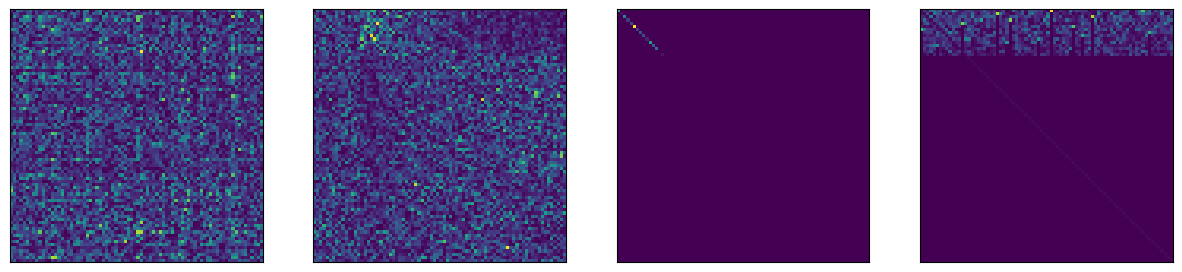

In [147]:
#k = 15
show(A, X, D, Y)

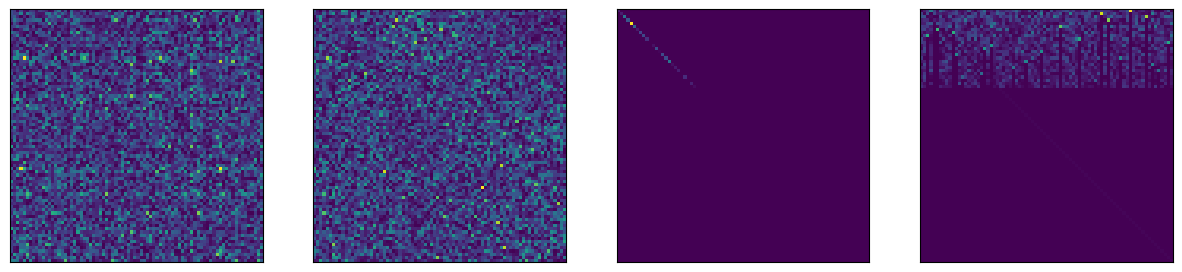

In [131]:
#k = 25
show(A, X, D, Y)

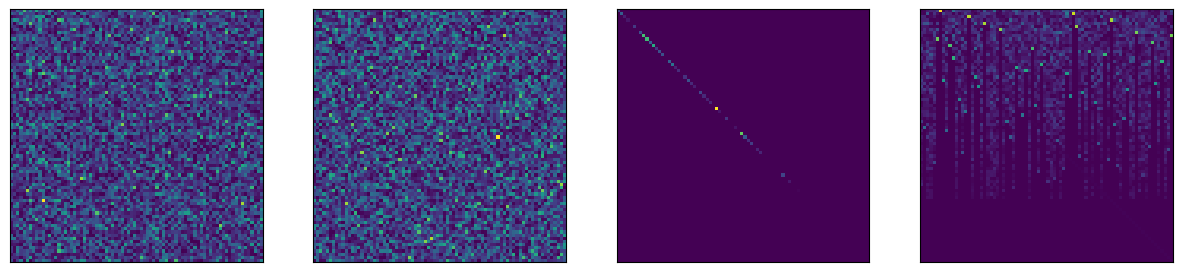

In [140]:
k = 60
show(A, X, D, Y)

In [14]:

Q, R, P = householder_with_pivoting(A, n)

AP = apply_permutation(A, P)

U, S, V = np.linalg.svd(A)

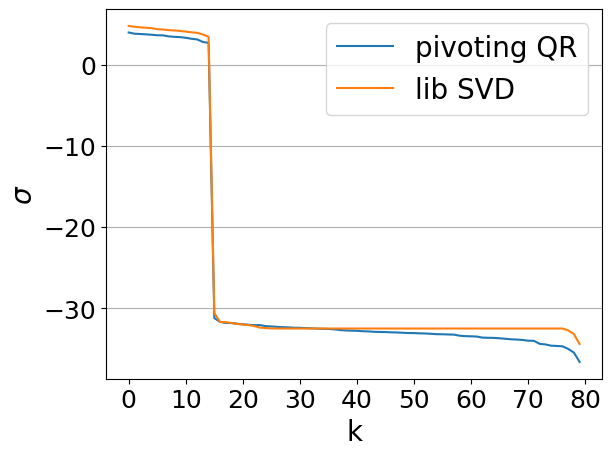

In [29]:
plt.plot(np.arange(n), np.log(np.abs(np.diag(R))), label="pivoting QR")
plt.plot(np.arange(n), np.log(np.abs(S)), label="lib SVD")
plt.legend(fontsize=20)
plt.xlabel("k", fontsize=20)
plt.ylabel("$\sigma$", fontsize=20)
plt.grid(axis='y')
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [155]:
qr_t, svd_t = speed(householder_with_pivoting, np.linalg.svd)

In [89]:
qr_t = [0.000919950143999813, 0.05767234009999811, 0.20581866299926332, 0.5161266429995521, 1.5640176879996943,1.723259291999966, 4.692810434999956, 4.8984895829999004,
5.7606876990003, 8.90299113799938, 12.075142686000618, 19.093206012000337, 20.016692291000254, 25.84642105399962, 33.10368065200055,40.603483662000144,
49.18410307799968, 56.34648683700016, 67.79546268600006, 77.46184040499975, 88.61456003499916, 100.87031587500132, 120.9767337180001, 134.76108637300058,
177.94320017499922, 194.91176243700102, 226.53186392099997, 249.2414385789998, 262.01367311599824,285.7443942329992]

In [90]:
svd_t = [3.44341832000282e-05, 0.003781279289996746,
 0.013924449890000688, 0.03179500249998455, 0.06670541469993622, 0.14147988500008069,
 0.18729046710004696, 0.28988331599975936, 0.3942557199998191, 0.5562663410000823,
 0.6898495559998992, 1.0571744429998944, 1.3262563259995659, 1.6771868709993214,
 2.1012167770004453, 2.5304693449998013, 3.164257959000679, 3.7790209980003056,
 4.750722300000234, 5.5103057689993875, 6.342960394000329, 8.19054972000049,
 9.298289088999809, 11.414837406000515, 13.83367910800007, 14.605234324000776,
 16.410889343000235, 18.62538120300087, 20.167137979999097, 22.941206791001605]

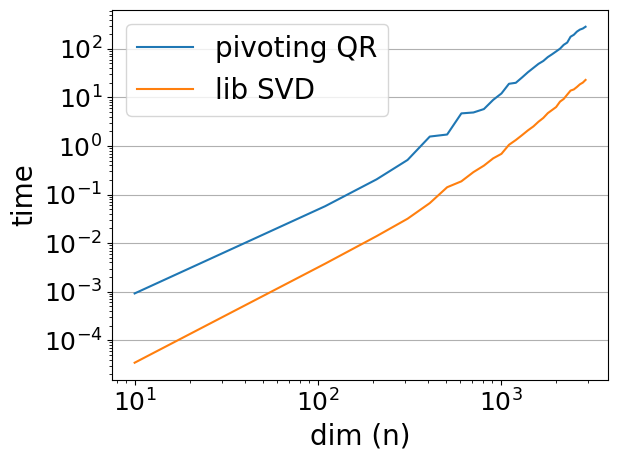

In [19]:
dim_range = [i for i in range(10, 3010, 100)]
plt.plot(dim_range, qr_t, label="pivoting QR")
plt.plot(dim_range, svd_t, label="lib SVD")
plt.legend(fontsize=20)
plt.xlabel("dim (n)", fontsize=20)
plt.ylabel("time", fontsize=20)
plt.yscale("log")
plt.xscale("log")
plt.grid(axis='y')
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

LU_1

In [160]:
n = 80
k = 60
eps = 0.0001 * np.random.randn(n, n)

# constructs matrix A with rank(A) = k
B = np.random.randn(n, k)
C = np.random.randn(k, n)
A = B @ C

In [161]:
P, PL, U = PLU(A)

In [162]:
# checking correctness:
#A - P.T@L@U
np.isclose(A, PL@U).all()

True

In [85]:
X = PL
D = np.diag(np.diag(U))
Y = U
np.fill_diagonal(Y, 1)

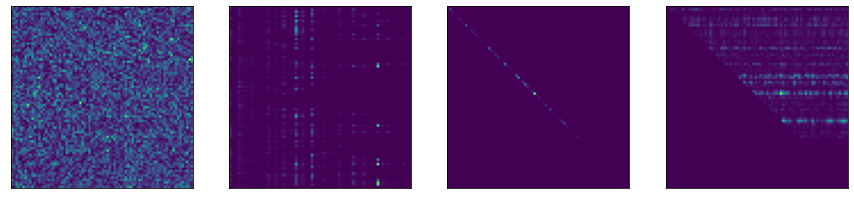

In [67]:
#k = 15
show(A, X, D, Y)

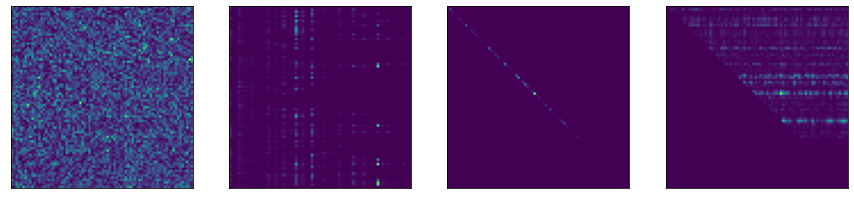

In [68]:
#k = 25
show(A, X, D, Y)

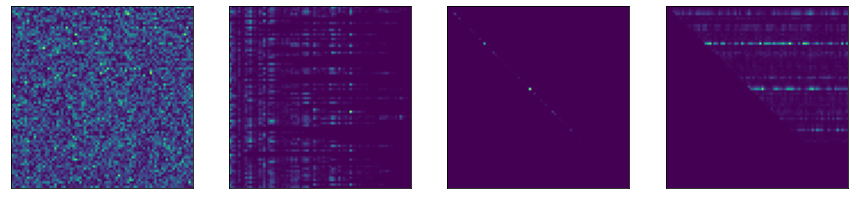

In [14]:
#k = 60
show(A, X, D, Y)

In [93]:
lu_t = speed_1(householder_with_pivoting, PLU)

In [106]:
qr_t_red, lu_t = speed(householder_with_pivoting, PLU, start=10, stop=1010, step=400)

In [107]:
svd_red_t = speed_1(np.linalg.svd, start=10, stop=1010, step=400)

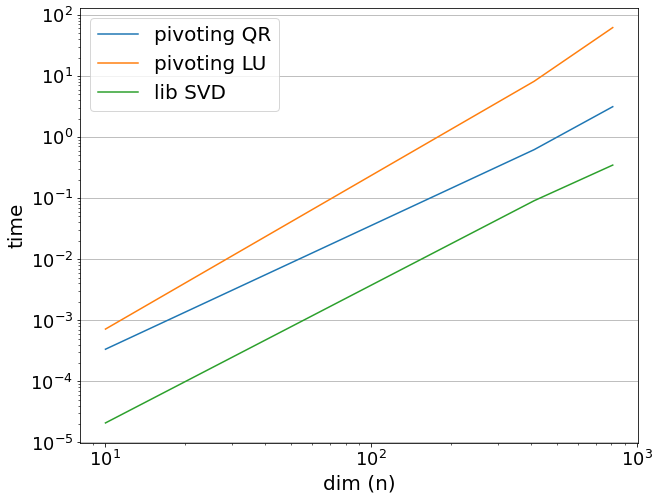

In [108]:
dim_range = [i for i in range(10, 1010, 400)]
plt.plot(dim_range, qr_t_red, label="pivoting QR")
plt.plot(dim_range, lu_t, label="pivoting LU")
plt.plot(dim_range, svd_red_t, label="lib SVD")
plt.legend(fontsize=20)
plt.xlabel("dim (n)", fontsize=20)
plt.ylabel("time", fontsize=20)
plt.yscale("log")
plt.xscale("log")
plt.grid(axis='y')
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

Rand RRQR

In [17]:
def single_sample_rand_qrcp(A, k, p=0, inplace=False):
    '''
Parameters:
    A - matrix to be decomposed
    k - targeted rank
    p - parameter to lessen a sample error
    inplace - whether data in A is overwritten
Returns:
    Q - unitary matrix
    R - upper-triangular matrix of size k times k
    '''
    if inplace:
        R = A
    else:
        R = copy.deepcopy(A)

    m, n = R.shape
    P = np.arange(n) # permutation matrix (in form of 1-d array) of matrix A columns

    Sigma = np.random.rand(k + p, m)
    B = Sigma @ A

    Q_b, R_b, P_b = linalg.qr(B, pivoting=True)
    #Q_b, R_b, P_b = qrcp(B, k+p)

    R = apply_permutation(R, P_b)

    Q, R = scipy.linalg.qr(R[:, :k])
    #R_12 = Q[:, :k].T @ R[:, k+1:]

    return Q, R, P_b

In [56]:
n = 80
k = 60
eps = 0.0001 * np.random.randn(n, n)

# constructs matrix A with rank(A) = k
B = np.random.randn(n, k)
C = np.random.randn(k, n)
A = B @ C

In [19]:
Q_2, R_2, P_2 = single_sample_rand_qrcp(A, n)

In [23]:
# checking correctness
P_A = set_Pmatrix(P_2)
np.isclose(A, (Q_2@R_2@P_A)).all()

True

In [ ]:
qr_t, rand_qr_t = speed(householder_with_pivoting, single_sample_rand_qrcp)

In [37]:
from matplotlib import rcParams

rcParams["figure.figsize"] = (10, )

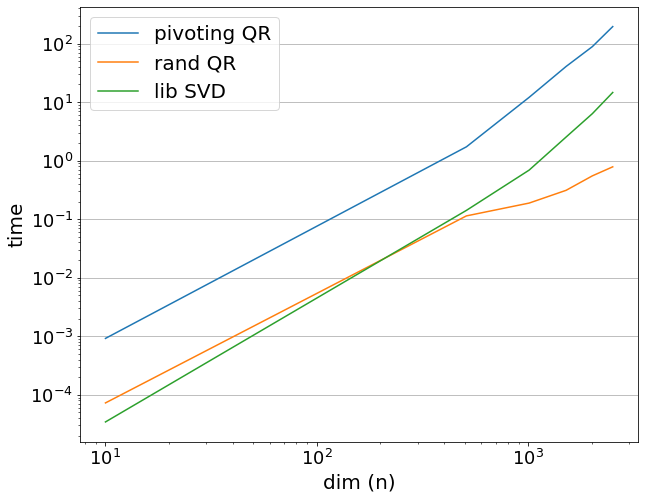

In [53]:
dim_range = [i for i in range(10, 3010, 200)]
plt.plot(dim_range, np.array(qr_t)[::5], label="pivoting QR")
plt.plot(dim_range, rand_qr_t, label="rand QR")
plt.plot(dim_range, np.array(svd_t)[::5], label="lib SVD")
plt.legend(fontsize=20)
plt.xlabel("dim (n)", fontsize=20)
plt.ylabel("time", fontsize=20)
plt.yscale("log")
plt.xscale("log")
plt.grid(axis='y')
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [75]:
Q, R, P = householder_with_pivoting(A, n)

Q_2, R_2, P_2 = single_sample_rand_qrcp(A, n)

U, S, V = np.linalg.svd(A)

P, PL, U = PLU(A)

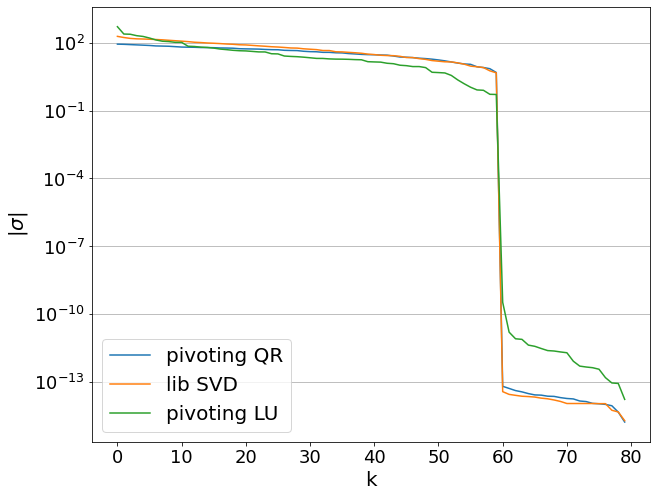

In [81]:
plt.plot(np.arange(n), np.abs(np.diag(R)), label="pivoting QR")
plt.plot(np.arange(n), np.abs(S), label="lib SVD")
plt.plot(np.arange(n), sorted(np.abs(np.diag(U)))[::-1], label="pivoting LU")
plt.legend(fontsize=20)
plt.yscale("log")
plt.xlabel("k", fontsize=20)
plt.ylabel("$|\sigma$|", fontsize=20)
plt.grid(axis='y')
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

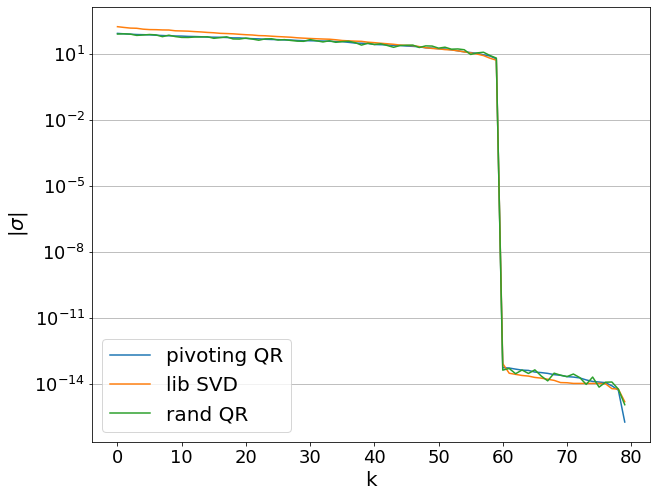

In [61]:
plt.plot(np.arange(n), np.abs(np.diag(R)), label="pivoting QR")
plt.plot(np.arange(n), np.abs(S), label="lib SVD")
plt.plot(np.arange(n), np.abs(np.diag(R_2)), label="rand QR")
plt.legend(fontsize=20)
plt.yscale("log")
plt.xlabel("k", fontsize=20)
plt.ylabel("$|\sigma$|", fontsize=20)
plt.grid(axis='y')
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [169]:
time_func_pQR = []
time_func_SVD = []
time_func_randQR = []
time_func_lu = []
#dim_range = [i for i in range(50, 3050, 400)]
   # k = int(n*60)
n = 2000
k = n
B = np.random.randn(n, k)
C = np.random.randn(k, n)
A = B @ C

for k in np.arange(10,n, 200):
    
    Q, R, P = householder_with_pivoting(A, n)   
    P_A = set_Pmatrix(P)
    time_func_pQR.append(linalg.norm(A-(Q[:, :k]@R[:k,:]@P_A), ord=2)/linalg.norm(A, ord=2))
    
    Q_2, R_2, P_2 = single_sample_rand_qrcp(A, n)
    P_A = set_Pmatrix(P_2)
    time_func_randQR.append(linalg.norm(A-(Q_2[:, :k]@R_2[:k,:]@P_A), ord=2)/linalg.norm(A, ord=2))
    
    U, S, Vh = np.linalg.svd(A)
    time_func_SVD.append(linalg.norm(A-np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vh[:k, :])), ord=2)/linalg.norm(A, ord=2))
    
    # P, PL, U = PLU(A)
    # time_func_lu.append(linalg.norm(A-(PL[:, :k]@U[:k,:]), ord=2)/linalg.norm(A, ord=2))

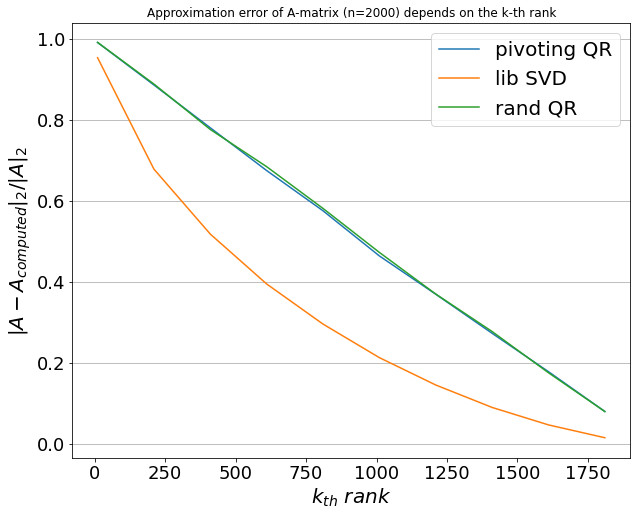

In [172]:
plt.plot(np.arange(10,n, 200), time_func_pQR, label="pivoting QR")
plt.plot(np.arange(10,n, 200), time_func_SVD, label="lib SVD")
plt.plot(np.arange(10,n, 200), time_func_randQR, label="rand QR")
plt.legend(fontsize=20)
# plt.yscale("log")
# plt.xscale("log")

plt.xlabel("$k_{th} \ rank$", fontsize=20)
plt.ylabel("$|A-A_{computed}|_2 / |A|_2$", fontsize=20)
plt.grid(axis='y')
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.title('Approximation error of A-matrix (n=2000) depends on the k-th rank')
plt.show()

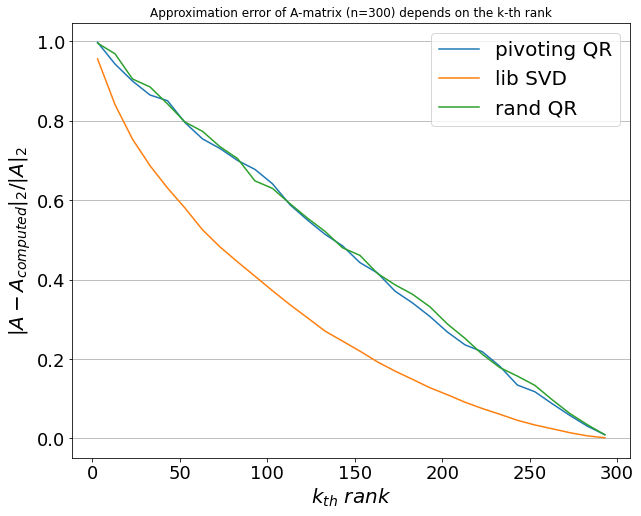

In [168]:
plt.plot(np.arange(3,n, 10), time_func_pQR, label="pivoting QR")
plt.plot(np.arange(3,n, 10), time_func_SVD, label="lib SVD")
plt.plot(np.arange(3,n, 10), time_func_randQR, label="rand QR")
plt.legend(fontsize=20)
# plt.yscale("log")
# plt.xscale("log")

plt.xlabel("$k_{th} \ rank$", fontsize=20)
plt.ylabel("$|A-A_{computed}|_2 / |A|_2$", fontsize=20)
plt.grid(axis='y')
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.title('Approximation error of A-matrix (n=300) depends on the k-th rank')
plt.show()